<a href="https://colab.research.google.com/github/MarcinWylot/CreditCardFraudDetectionKaggleDS/blob/master/CreditCardFraudDetectionKaggleDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
#from google.colab import files
#uploaded = files.upload()

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
#uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
#uploaded.SetContentString('Sample upload file content')
#uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': '1QQara53mzPKgRO4poTIWtQ2Ijm3GcqkV'})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('./creditcard.csv')
!ls


adc.json  creditcard.csv  sample_data


In [4]:
data = pd.read_csv('./creditcard.csv')
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
#data.describe()
X_train_full, X_test = train_test_split(data, test_size=0.2, random_state=0)

#X_train = data[data.Class == 0]
X_train = X_train_full
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
#X_train = X_train.values

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
#X_test = X_test.values


fraud = X_train_full[X_train_full['Class'] == 1]
valid = X_train_full[X_train_full['Class'] == 0]

fraud_fraction = len(fraud) / float(len(valid))
print(fraud_fraction)

0.0017190289025473282


In [5]:
from sklearn.ensemble import IsolationForest
clf_IsolationForest = IsolationForest(max_samples = len(X_test), contamination = fraud_fraction, random_state=1)

clf_IsolationForest.fit(X_train)
y_IsolationForest = clf_IsolationForest.predict(X_test)

y_IsolationForest[y_IsolationForest == 1] = 0
y_IsolationForest[y_IsolationForest == -1] = 1

print(accuracy_score(y_test,y_IsolationForest))
print(classification_report(y_test,y_IsolationForest))

0.9976475545100242
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.33      0.33      0.33       101

avg / total       1.00      1.00      1.00     56962



In [6]:
#it's not the best method to test unseen data 
from sklearn.neighbors import LocalOutlierFactor
clf_LocalOutlierFactor = LocalOutlierFactor(n_neighbors=20, contamination = fraud_fraction)

clf_LocalOutlierFactor.fit(X_train)
y_LocalOutlierFactor = clf_LocalOutlierFactor._decision_function(X_test)

threshold = np.histogram(y_LocalOutlierFactor,bins=2)[1][1]

y_pred = np.zeros(X_test.shape[0], dtype=int)
y_pred[y_LocalOutlierFactor < threshold] = 1

      
print(accuracy_score(y_test,y_pred)) 
print(classification_report(y_test,y_pred))

0.9981039991573329
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.00      0.00      0.00       101

avg / total       1.00      1.00      1.00     56962



In [7]:
#https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

X_train = X_train_full[X_train_full.Class == 0] #we tain the model on normal transaction only 
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard]).history


predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

print(np.histogram(error_df.reconstruction_error.values,bins=4))


(array([56960,     1,     0,     1]), array([6.13694879e-02, 4.04979290e+02, 8.09897210e+02, 1.21481513e+03,
       1.61973305e+03]))


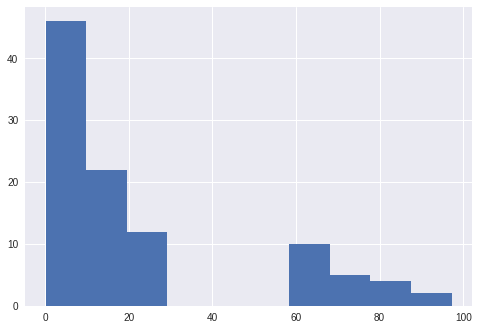

In [23]:
error_df[error_df['true_class'] == 1].reconstruction_error.hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


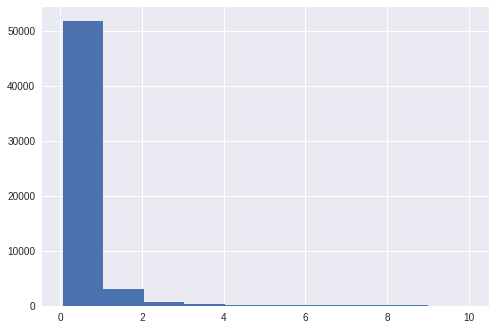

In [31]:
error_df[error_df['true_class'] == 0][error_df['reconstruction_error'] < 10].reconstruction_error.hist()

In [39]:
threshold_range = 20
for threshold in np.linspace(0,threshold_range,threshold_range*2):
  y_pred = np.zeros(X_test.shape[0], dtype=int)
  y_pred[error_df.reconstruction_error.values > threshold] = 1

  print("threshold:", threshold)
  print("roc_auc_score:", roc_auc_score(y_test, y_pred)) 
  print(classification_report(y_test,y_pred))

threshold: 0.0
roc_auc_score: 0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     56861
          1       0.00      1.00      0.00       101

avg / total       0.00      0.00      0.00     56962

threshold: 0.5128205128205128
roc_auc_score: 0.7942886953263307
             precision    recall  f1-score   support

          0       1.00      0.64      0.78     56861
          1       0.00      0.95      0.01       101

avg / total       1.00      0.64      0.78     56962

threshold: 1.0256410256410255
roc_auc_score: 0.9080404690193786
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     56861
          1       0.02      0.91      0.03       101

avg / total       1.00      0.91      0.95     56962

threshold: 1.5384615384615383
roc_auc_score: 0.9054736746427496
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     56861
          1       0.03

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56861
          1       0.08      0.75      0.14       101

avg / total       1.00      0.98      0.99     56962

threshold: 4.615384615384615
roc_auc_score: 0.8298451791680286
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56861
          1       0.08      0.67      0.14       101

avg / total       1.00      0.99      0.99     56962

threshold: 5.128205128205128
roc_auc_score: 0.8207004191740115
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56861
          1       0.09      0.65      0.15       101

avg / total       1.00      0.99      0.99     56962

threshold: 5.6410256410256405
roc_auc_score: 0.806297396064504
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56861
          1       0.09      0.62      0.16       101

avg /